In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import glob
import pandas as pd
import os
from scipy import signal
import DasPrep as dp


# import pyproj

from nptdms import TdmsFile
import DasPrep as idas

# datapath = 'G:\\xfj_das\\'
workpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/'
savefigpath = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize_fig/'
# savefigpath_refine = 'D:\\sustech_dir\\workdir\\das-event_reorganize_fig_2\\'
resave_npy_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/data/'

save_csv_path = '/home/wuzm/data/DAS_DL_Dataset/DASEventData/phase_picks/'
eq_catalog_file = '/home/wuzm/data/DAS_DL_Dataset/data/xfj/DetectedFinal.dat'

# datapath = '/home/disk/disk02/bluo/xfj_das/'
# das_file = glob.glob(datapath+'*.tdms')
# das_file.sort()

# dp.read_das(das_file[0], metadata='True')

In [2]:
eq_cat = pd.read_csv(eq_catalog_file, delim_whitespace=True)


eq_time = np.array([datetime.datetime.strptime(str(eq_cat['Date'].values[i])+' '+str(eq_cat['Time'].values[i]), '%Y/%m/%d %H:%M:%S.%f') 
       for i in range(len(eq_cat))])

# eq_time = eq_time - datetime.timedelta(seconds=8*3600)   # this catalog was in UTC

lat = eq_cat['Lat.'].values
lon = eq_cat['Lon.'].values
mag = eq_cat['Mag.'].values
dep = eq_cat['Dep.'].values
Coef = eq_cat['Coef.'].values

ev_files = glob.glob(workpath+'*.npy')
get_number_in_file =  lambda x: int(os.path.basename(x).split('_')[-1].split('.')[0])
ev_files.sort(key=get_number_in_file)
print(len(eq_cat[mag>0.5]))
eq_cat[mag == 0.87]
 # strong mag


24


#No.        Date          Time    Lat.     Lon.  Dep.  Mag.   Coef.  \
114    18  2022/04/25  06:42:05.162  23.854  114.505   7.6  0.87  0.8567   
284     3  2022/05/09  04:11:53.321  23.844  114.508   7.9  0.87  0.8345   

     N(*MAD)     Reference  
114  50.8707  2.022043e+13  
284  57.7650  2.022042e+13

/home/wuzm/data/DAS_DL_Dataset/data/xfj/das_event_reorganize/xfj_das_re_eq_151.npy
(2944, 8000)


<IPython.core.display.Javascript object>


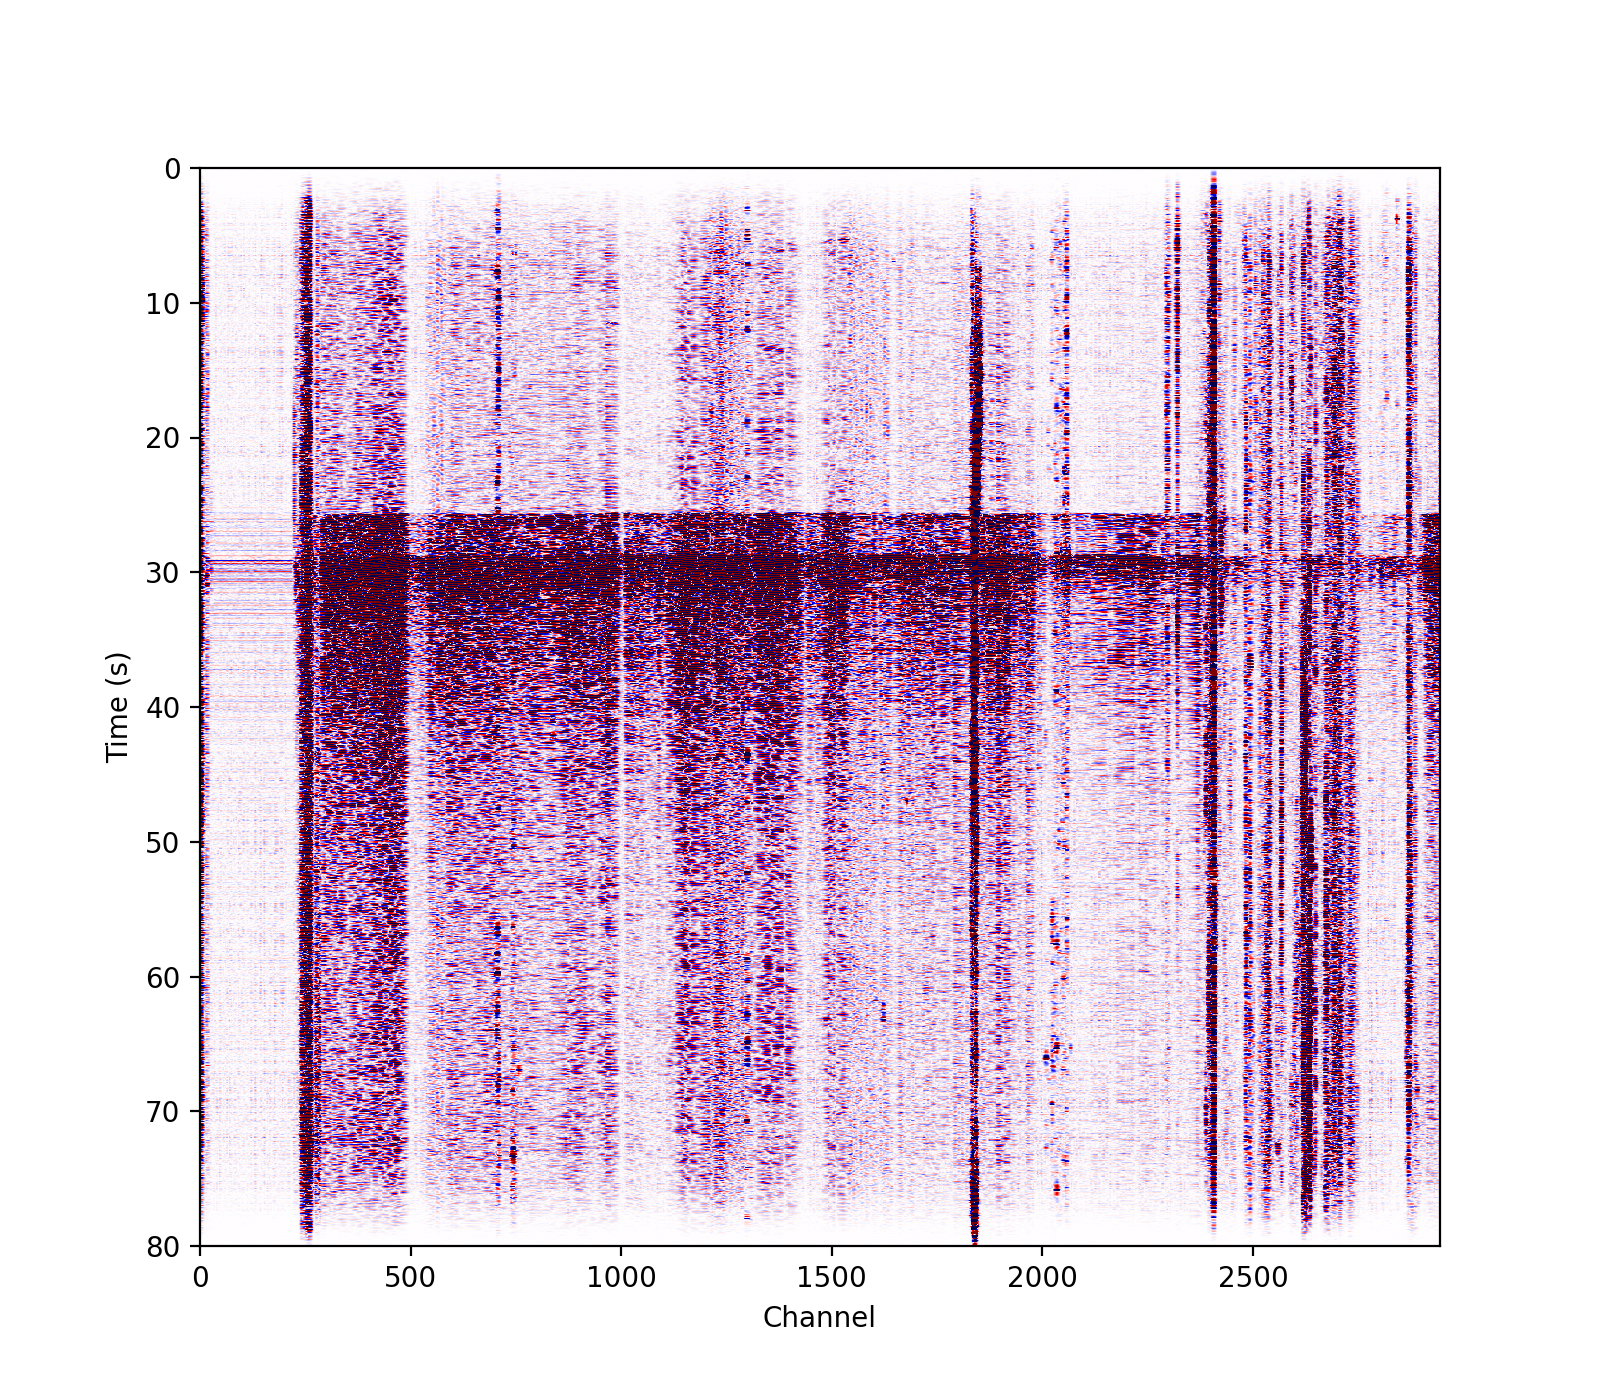

In [3]:
%matplotlib notebook
import matplotlib.animation as animation
import das_event_manual_pick as das_mp
from scipy import signal
import DasPrep as dp
from datetime import datetime, timedelta


dt_before, dt_after = 20, 60

save_file_name_prefix = workpath + 'xfj_das_re_eq_'


iev = 151
# if len(list(click_pos.keys()))>0:
#     iev = max(list(click_pos.keys())) + 1
# else:
#     iev = 21

savename = save_file_name_prefix + str(iev) + '.npy'

fq = 300
dt = 1./300.
print(savename)
data = np.load(savename)
# down sample and save raw data 
data = signal.decimate(data, 3, axis=-1).astype('float32')
dt *= 3
fq = 100 
resave_name = resave_npy_path + 'xfj_das_100Hz_' + str(iev) + '.npy'
np.save(resave_name, data.astype('float32'))

# data process
data = dp.das_preprocess(data)
f1, f2 = 15, 35
f1, f2 = 1, 20
data = dp.bandpass(data * signal.windows.tukey(data.shape[1], alpha=0.2), dt, fl=f1, fh=f2)

print(data.shape)

# plot hot map to find the arrive time
# https://stackoverflow.com/questions/39079562/matplotlib-animation-vertical-cursor-line-through-subplots
fig, ax = plt.subplots(figsize=[8,7])

clim = data.std() * 0.1

ax.imshow(data[:, :].T, aspect='auto', cmap ='seismic', 
           vmin = -clim, vmax = clim,
          extent=[0,data.shape[0], data.shape[1]*dt, 0])

# ax.set_ylim([5, 1])
ax.set_xlabel('Channel')
ax.set_ylabel('Time (s)')

plt.show()

<IPython.core.display.Javascript object>


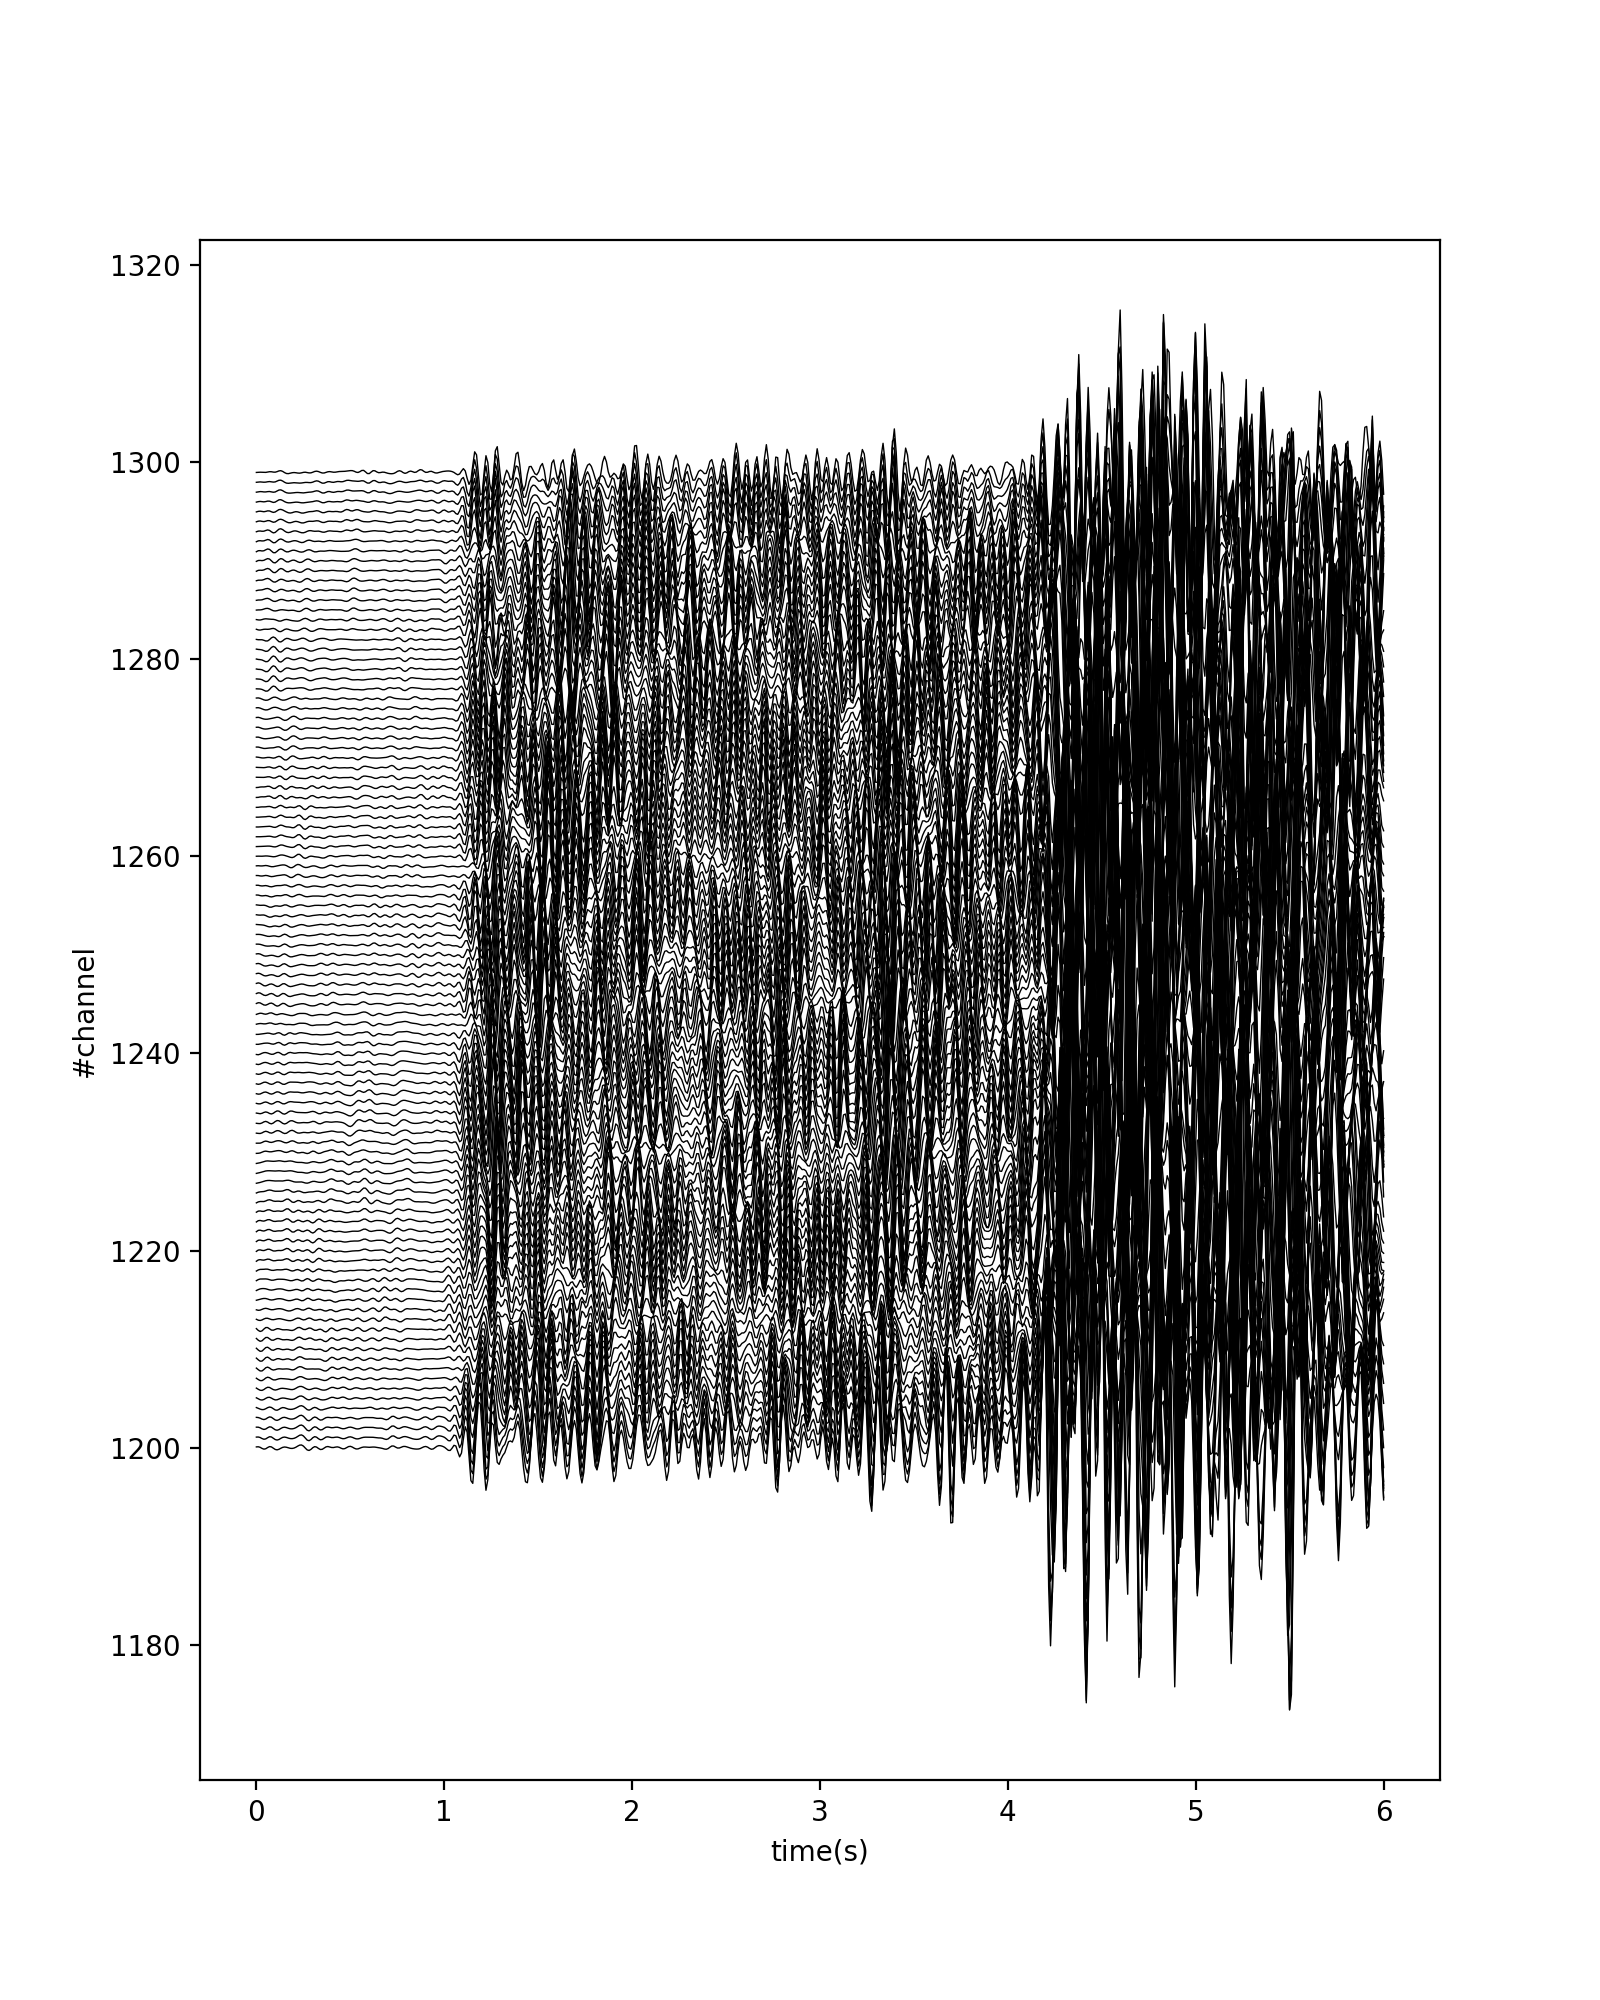

In [7]:
%matplotlib notebook
import matplotlib.animation as animation
from scipy import signal
click_pos = {}
line_x , line_y = list() , list() #time and channel

def onMouseMove(event, axx):
    axx.lines = [] #axx.lines[:1]
    axx.axhline(y=event.ydata, color="k" , linewidth=3)
    axx.axvline(x=event.xdata, color="k" , linewidth=3)
    ax.figure.canvas.draw()

def onMouseClick(event, axx):
    print(event.xdata, event.ydata)
    click_pos[int(event.ydata)] = event.xdata 
    axx.scatter(x=event.xdata, y=event.ydata ,  s=2 )
    
    line_x.append(event.xdata)
    line_y.append(event.ydata)

    axx.plot(line_x , line_y ,linewidth=1)
    axx.figure.canvas.draw()

    

class Click():
    def __init__(self, ax, func, button=1):
        self.ax=ax
        self.func=func
        self.button=button
        self.press=False
        self.move = False
        self.c1=self.ax.figure.canvas.mpl_connect('button_press_event', self.onpress)
        self.c2=self.ax.figure.canvas.mpl_connect('button_release_event', self.onrelease)
        self.c3=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onmove)

    def onclick(self,event):
        if event.inaxes == self.ax:
            if event.button == self.button:
                self.func(event, self.ax)
    def onpress(self,event):
        self.press=True
    def onmove(self,event):
        if self.press:
            self.move=True
    def onrelease(self,event):
        if self.press and not self.move:
            self.onclick(event)
        self.press=False; self.move=False
        
        
class MouseMove:
    def __init__(self, ax, func):
        self.ax=ax
        self.func = func
        self.c1=self.ax.figure.canvas.mpl_connect('motion_notify_event', self.onMouseMove)
    def onMouseMove(self,event):
        if event.inaxes == self.ax:
            self.func(event, self.ax)

####
das_ch1 , das_ch2 = 1200 , 1300
t1 , t2 = 24.5,30.5
data2 = data[: , int(fq * t1) : int(fq * t2) ]

# data2 = np.cumsum(data2, axis=1) #计算应变率

def moving_average(x, w):
    return np.convolve(x, np.ones(w), "valid") / w

def smooth2(a, nx, ny):
    kernel = np.ones((nx,ny)) * 1 / (nx * ny)
    r = signal.convolve2d(a, kernel, mode = 'same')
    return r

# data2 = smooth2( data2 , 10 , 1  ) #滑动平均

fig, ax = plt.subplots( figsize=(8, 10))
for i in range(das_ch1 , das_ch2 , 1 ):
    ax.plot(np.linspace(0 ,  data2.shape[1]*dt  , data2.shape[1] )   , data2[i]/100 + i, 'k', linewidth=0.5)
ax.set_ylabel("#channel")
ax.set_xlabel("time(s)")
    
click = Click(ax, onMouseClick, button=1)
mm    = MouseMove(ax, onMouseMove)

plt.show()


In [ ]:
# 选更清晰的震级 
# 精细打点 通道间隔1 100道需要15-20分钟
#粗略打点 通道间隔1  100道需要3分钟  结果对比 
#通道间隔大约为3 的效果更好
# 整理流程时间

<IPython.core.display.Javascript object>


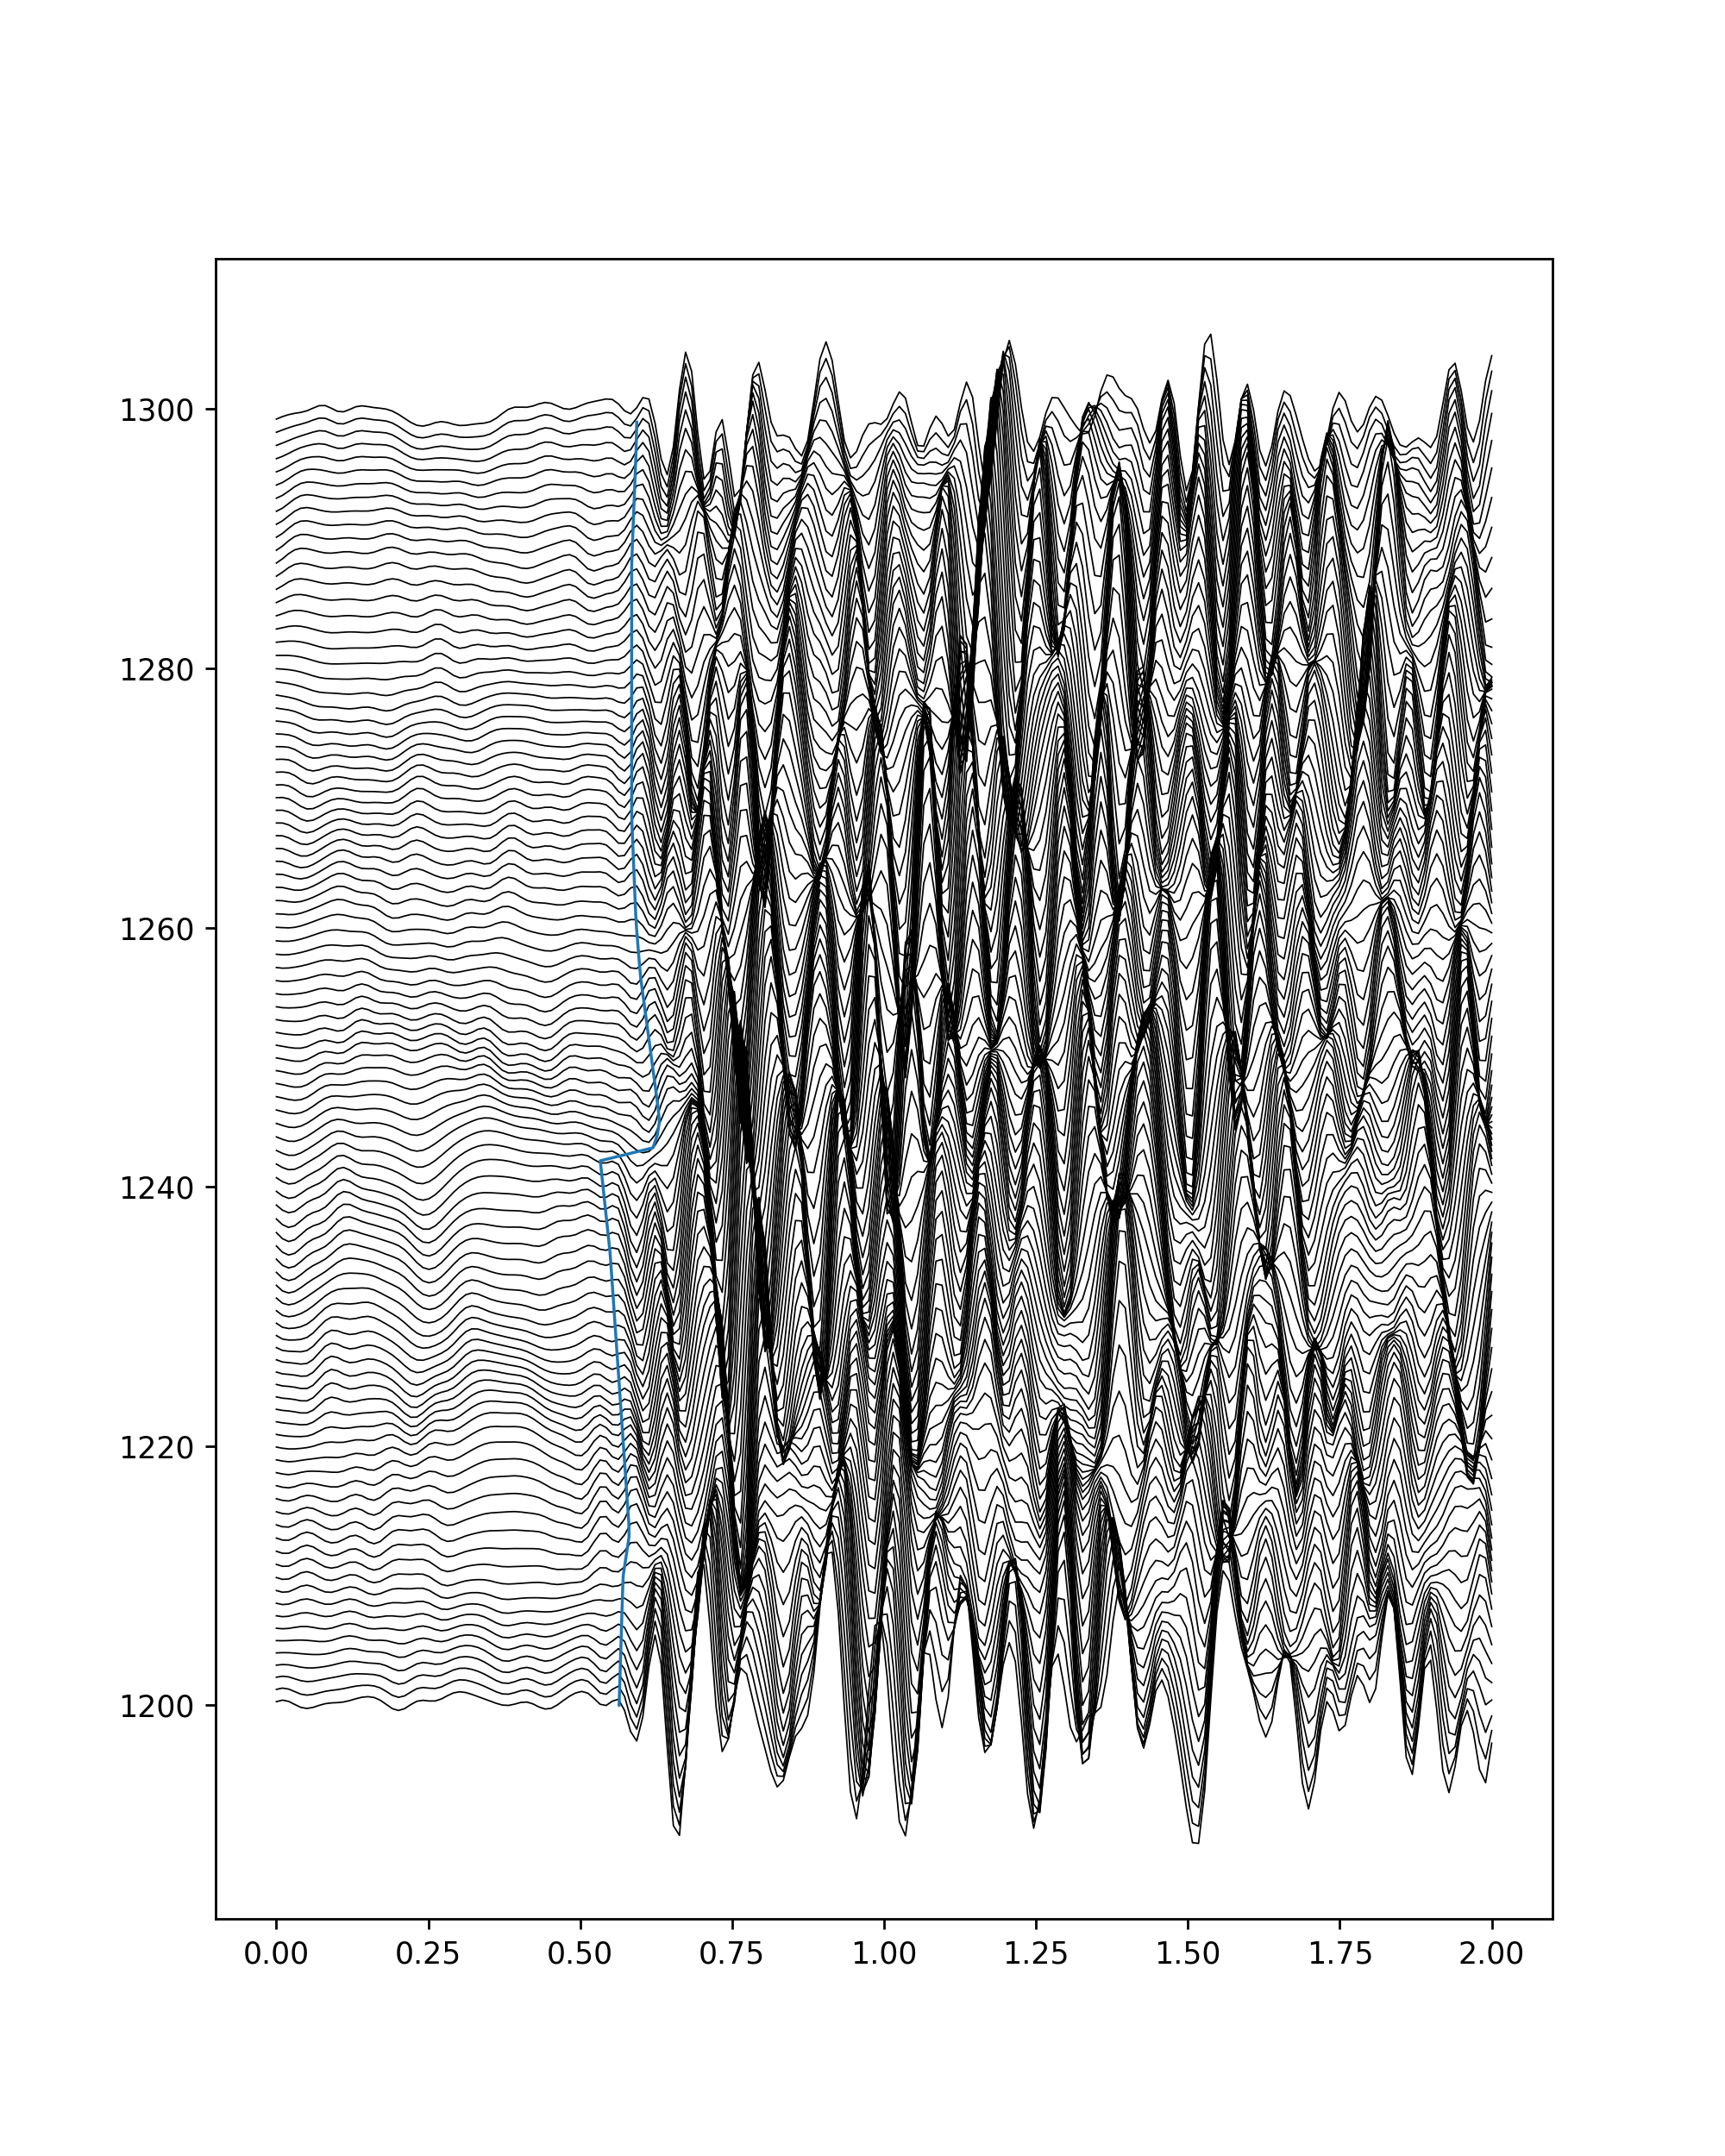

In [24]:
from scipy import interpolate
import csv
from datetime import datetime, timedelta

# 定义需要插值的点
ch_list = np.arange(das_ch1 , das_ch2 , dtype=np.int16)
# 进行线性插值
f1=interpolate.interp1d(line_y , line_x , kind='linear')
time_list =f1(ch_list)

fig, ax = plt.subplots( figsize=(8, 10))
for i in range(das_ch1 , das_ch2 ):
    ax.plot( np.linspace(0 ,  data2.shape[1]*dt  , data2.shape[1] ) , data2[i]/50 + i, 'k', linewidth=0.5)
ax.plot(time_list , ch_list , linewidth=1)


#写入csv
csv_file_path = save_csv_path + 'xfj_das_100Hz_' + str(iev) + '.csv'

with open(csv_file_path,"a+") as csvfile: 
    writer = csv.writer(csvfile)
    #先写入columns_name
    # writer.writerow(["channel_index","phase_index","phase_time","phase_score","phase_type"])
    #dtype: int32,int32,str,float32,str
    # e.g.:1000,3000,2019-07-04T17:33:520000+00:00,0.98,P
    #写入多行用writerows
    
    # arglist = ['Date', 'Time', 'Lat.', 'Lon.', 'Mag.', 'Dep.']

# eq_cat.iloc[ieq][arglist]
    for i in range(das_ch1 , das_ch2):
        channel_index =  i 
        phase_index = (f1(i) + t1) * fq 
        t = datetime.strptime(eq_cat.iloc[iev]['Date'] +"_"+ eq_cat.iloc[iev]['Time'], '%Y/%m/%d_%H:%M:%S.%f')
        phase_time = t + timedelta(seconds=f1(i) + t1 - 20) 
        phase_score = eq_cat.iloc[iev]['Mag.']
        phase_type = "P"
        writer.writerow([channel_index , phase_index ,phase_time , phase_score , phase_type ])


